<a href="https://colab.research.google.com/github/AllieUbisse/end-to-end-ml/blob/master/notebooks/Quick_feature_selection_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Attribute information:

##Input variables:
### **bank client data**:
1 - age (numeric)

2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                  "blue-collar","self-employed","retired","technician","services") 

3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)

4 - education (categorical: "unknown","secondary","primary","tertiary")

5 - default: has credit in default? (binary: "yes","no")

6 - balance: average yearly balance, in euros (numeric) 

7 - housing: has housing loan? (binary: "yes","no")

8 - loan: has personal loan? (binary: "yes","no")

###  **related with the last contact of the current campaign:**

9 - contact: contact communication type (categorical: "unknown","telephone","cellular") 

10 - day: last contact day of the month (numeric)

11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")

12 - duration: last contact duration, in seconds (numeric)

### **other attributes**:

13 - campaign: number of contacts performed during this campaign and for this client (numeric, 
includes last contact)

14 - pdays: number of days that passed by after the client was last contacted from a previous 
campaign (numeric, -1 means client was not previously contacted)

15 - previous: number of contacts performed before this campaign and for this client (numeric)

16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")


### **Output variable (desired target):**
17 - y - has the client subscribed a term deposit? (binary: "yes","no")

# imports

In [0]:
# Data manipulation imports
import pandas as pd
import numpy as np
import zipfile

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# preprocessing
from sklearn.model_selection import train_test_split

# feature selection imports
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# model evaluation imports

# ML algorithms imports

# Load data

In [116]:
# set data urls
bank_full_url ='https://raw.githubusercontent.com/AllieUbisse/DataHouse/master/bank/bank-full.csv'
bank_url = 'https://raw.githubusercontent.com/AllieUbisse/DataHouse/master/bank/bank.csv'

# read data 
bank = pd.read_csv(bank_url, delimiter=';')
bank_full = pd.read_csv(bank_full_url, delimiter=';')
bank.shape, bank_full.shape

((4521, 17), (45211, 17))

# EDA

In [117]:
# view full data
bank_full.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [28]:
# get data types 
bank_full.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [49]:
# class distribution
bank_full.groupby(['y']).size()

y
no     39922
yes     5289
dtype: int64

In [136]:
bank_full.groupby(['job']).size()

job
admin.           5171
blue-collar      9732
entrepreneur     1487
housemaid        1240
management       9458
retired          2264
self-employed    1579
services         4154
student           938
technician       7597
unemployed       1303
unknown           288
dtype: int64

In [138]:
bank_full[ bank_full['job'] == 'unknown' ]['age']

4        33
216      47
354      59
876      37
1072     29
         ..
44714    45
44742    64
44970    28
45141    77
45186    59
Name: age, Length: 288, dtype: int64

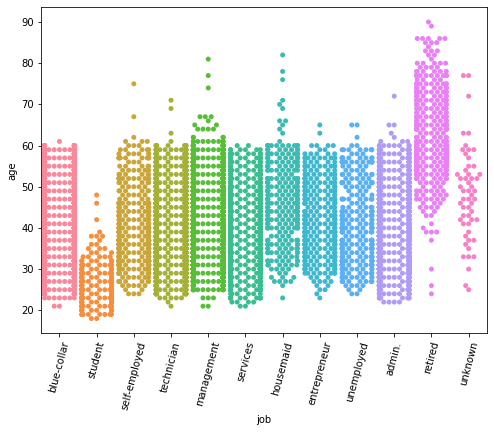

In [158]:
# set size of the figure
plt.figure(figsize=(8,6))

# plot age vs jobs 
sns.swarmplot(x='job', y='age', data=bank_full.sample(10000))
plt.xticks(rotation=75)
plt.show()

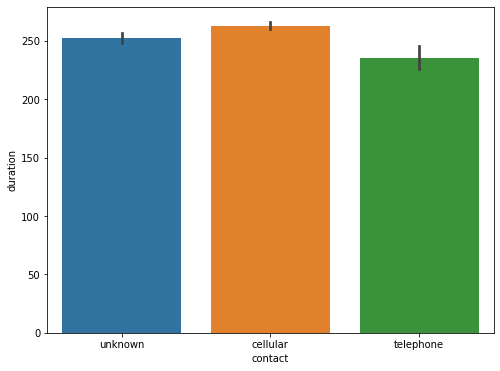

In [176]:
# set size of the figure
plt.figure(figsize=(8,6))

# bar plot for  contacts
sns.barplot(x='contact', y='duration', data=bank_full) 

In [0]:
bank_full['campaign_by_duration'] = (bank_full['campaign'] * bank_full['duration'])

In [235]:
corr_matrix = bank_full.corr(method='pearson')
corr_matrix['y'].abs().sort_values(ascending=False)

y                              1.000000
duration                       0.394521
duration_per_day               0.231161
campaign_by_duration           0.207921
housing                        0.139173
day_per_duration               0.122337
pdays+previous_per_campaign    0.108437
pdays+previous                 0.108437
pdays-previous_per_campaign    0.106143
pdays-previous                 0.106143
pdays                          0.103621
previous                       0.093236
campaign_per_duration          0.079050
campaign                       0.073172
loan                           0.068185
balance                        0.052838
day_per_campaign               0.050953
day                            0.028348
age                            0.025155
default                        0.022419
balance_per_campaign           0.015558
Name: y, dtype: float64

# DATA preprocessing

In [159]:
[col for col in bank_full.select_dtypes(exclude='number').columns if bank_full[col].str.contains('unknown').sum()>0]

['job', 'education', 'contact', 'poutcome']

In [0]:
def binary_to_int(df, drop_orginal=False):

    # get all binary cols with yes and no
    binary_col = [col for col in df.select_dtypes(exclude='number').columns if df[col].str.contains('yes').sum()>0 ]
     
    # convert binary to int, where yes =1 and no=0
    for col in binary_col:
      df['_'+col] = np.where(df[col] == 'yes', 1, 0, )

    # if drop_orginal is True drop yes no cols else return dataframe with orginal cols
    if drop_orginal:
         df.drop(labels=binary_col, axis=1, inplace=True)
         df.columns = df.columns.str.replace('_','')
         return df

    else:
      return df

In [165]:
# Cast binary to int
bank_full = binary_to_int(bank_full, drop_orginal=False)

# view transformed columns
bank_full.sample(5)

,age,job,marital,education,balance,contact,day,month,duration,campaign,pdays,previous,poutcome,default,housing,loan,y
4198,31,blue-collar,married,primary,2085,unknown,19,may,488,3,-1,0,unknown,0,1,1,0
24421,43,technician,married,secondary,0,cellular,17,nov,103,2,193,3,failure,0,0,1,0
30341,28,services,single,secondary,1820,cellular,5,feb,134,2,203,1,success,0,1,0,0
9921,38,housemaid,divorced,primary,359,unknown,9,jun,242,4,-1,0,unknown,0,0,0,0
14080,41,technician,married,secondary,-172,cellular,11,jul,132,2,-1,0,unknown,0,1,1,0


In [167]:
bank_full.dtypes

age           int64
job          object
marital      object
education    object
balance       int64
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
default       int64
housing       int64
loan          int64
y             int64
dtype: object

In [166]:
# separate the target from predictors
X = bank_full.drop('y', axis=1)
y = bank_full.y

# split data into train test
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=1996)

# view dimension of train and validation
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((31647, 16), (13564, 16), (31647,), (13564,))

# Feature Engineering

In [0]:
# define the SelectKBest class instance
kbest =  SelectKBest(score_func=chi2, k=10)

# fit data 


# Modeling